# Implementación técnica y resumen del paper de la KAN (Kolmogorov-Arnold networks)


In [2]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
import torch.optim as optim



Así como los MLP están basados en el teorema de aproximación por funciones, este abril de 2024 se publicó un paper https://arxiv.org/pdf/2404.19756, donde se detalló otro tipo de arquitectura, llamada KAN, en honor y en base al teorema de Kolmogorov Arnold.
Estos dos teoremas comparados son los siguientes:

* El teorema de aproximación universal establece que toda función entre compactos puede ser aproximada por una red neuronal
con un número de neuronas finito.
* EL teorema de Kolmogorov-Arnold nos dice que cualquier función multivariable continua puede ser 
aproximada como una composición finita de funciones continuas de una variable y la operación binaria 
de adición. Específicamente:
    $$f(x) = f(x_1, x_2, \ldots, x_n) = \sum_{q=0}^{2n} \Phi_q (\sum_{p=1}^n \phi_{q, p}(x_p))$$
   Donde:
   $$\phi_{q, p}: [0, 1] \longrightarrow \mathbb{R} \text{ y } \Phi_q: \mathbb{R} \longrightarrow \mathbb{R}$$
   
   
En concreto, la implementación del ajuste de este paradigma se realiza utilizando splines u otros aproximadores de funciones en vez de las $\phi, \Phi$. 

## Ventajas notorias de esta familia de estimadores con respecto a las redes neuronales es:
* Se necesitan menos parámetros para alcanzar un mismo resultado con respecto a una MLP
* El resultado es altamente interpretable, a diferencia de una MLP
* Se puede extraer una fórmula prácticamente concisa, interviniendo elementos no lineales. Una MLP tiene demasiados términos para que esto sea practicable.


### Comparación de número de parámetros.

1. Sea L la profundidad de ambas redes.
2. Sea N el número de pesos de una neurona.
3. Sea G el número de puntos en los que se divide un grid [0, 1]

Asumiendo dos redes neuronales (MLP, KAN), de L capas y con la misma anchura en cada capa. $n_0 = n_1 = \ldots = n_L = N$

* Una red neuronal tiene en total $O(N^2L)$
* Una KAN tiene en total $O(N^2LG)$, ya que para cada entrada en la matriz de funciones antes presentada, tenemos en total G pesos, uno por cada elemento del grid (Esto si utilizamos B-splines para la estimación de los splines)


## Implementación técnica


En una MLP, tenemos varias capas, y en cada una de las capas, tenemos asociada una matriz de pesos, que encierra las relaciones entre los valores de la capa (L) y la capa (L-1), despue's de aplicar la función de activación correspondiente. Es decir:
$$ a^{(L)} = \sigma(W_{n_L, n_{L-1}} a^{(L-1)})$$

En comparación, podemos establecer una capa de KAN como una matriz de funciones de una dimensión:
$$\Phi = {\phi_{q, p}}, p = 1, 2, \ldots, n_{in}, q = 1, 2, \ldots, n_{out}$$
Donde estas funciones tienen parámetros entrenables (splines). Las funciones internas forman una capa KAN de dimensión $$(n_{in}, n_{out}) = (n, 2n+1)$$ mientras que las funciones externas forman una capa de dimensión
$$(n_{in}, n_{out}) = (2n+1, 1)$$

Entre las capas l y l+1, existen $$n_l n_{l+1}$$ funciones



La forma matricial puede ser escrita como
$$
x_{l+1} =
\begin{pmatrix}
\phi_{l,1,1}(\cdot) & \phi_{l,1,2}(\cdot) & \cdots & \phi_{l,1,n_l}(\cdot) \\
\phi_{l,2,1}(\cdot) & \phi_{l,2,2}(\cdot) & \cdots & \phi_{l,2,n_l}(\cdot) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{l,n_{l+1},1}(\cdot) & \phi_{l,n_{l+1},2}(\cdot) & \cdots & \phi_{l,n_{l+1},n_l}(\cdot)
\end{pmatrix}
x_l,
$$
Que es equivalente a 
$$x_{l+1} = \Phi_l x_{l}$$
Donde $\Phi_l$ es la matriz de funciones correspondiente a la capa $l$
Una KAN general es la composición de L de estas capas. Para un vector $x_0 \in \mathbb{R}^{n_0}$, el output de una KAN es:
$$
\text{KAN}(x) = (\Phi_{L-1} \circ \Phi_{L-2} \circ \cdots \circ \Phi_1 \circ \Phi_0)x.
$$



### Teorema clave para la aproximación de esta familia de estimadores a funciones:

$$\textbf{Teorema (teoría de la aproximación).}  $$
Sea $x = (x_1, x_2, \dots, x_n)$. Supongamos que $f(x)$  admite una representación
$$
f = (\Phi_{L-1} \circ \Phi_{L-2} \circ \cdots \circ \Phi_1 \circ \Phi_0)x,
$$
donde cada uno de los $\Phi_{l,i,j}$ son $(k+1)$-veces continuamente diferenciables. Entonces, existe una constante $C$ dependiente de $f$ y su representación. Esto nos da la siguiente cota dependiente del grid escogido: Existen unas $k$ B-spline funciones  $\Phi_{l,i,j}^G$ tal que para cada  $0 \leq m \leq k$, tenemos la cota
$$
\|f - (\Phi_{L-1}^G \circ \Phi_{L-2}^G \circ \cdots \circ \Phi_1^G \circ \Phi_0^G)x\|_{C^m} \leq C G^{-k-1+m}.
$$

Este teorema nos permite extraer que cuando mejoramos el grid de los splines, tenemos garantizado que el error en la norma dada disminuirá. Esta norma está definida como:
$$\|g\|_{C^m} = max_{|\beta| \leq m} sup_{x \in [0, 1]^n} |D^{\beta} g(x) |$$


Conclusión: Podemos aproximar la función representativa de f modificando el gridline (cuanto más fino, más nos aproximaremos)

#### En vez de utilizar un grid para estimar los splines con B-Splines, aproximaremos los splines con desarrollos de taylor.

Este teorema que hemos visto tiene una implicación análoga cuanto mejor aproximamos los splines por separado

Definimos la clase capaKAN_taylor. Esta es la que usaremos para estimar las funciones de activación utilizadas en las capas KAN, mediante el uso del desarrollo de taylor.

### Definición de la capa KAN

Como puede observarse en el paper, cada capa se compone de una matriz de funciones, donde la multiplicación "matricial" está definida como la sustitución de los valores en cada función, como hemos visto antes. Cada uno de estos $\phi$ está definida de la siguiente forma, como viene explicado en el paper:

se incluye una función base $ b(x)$ tal que la función $\phi(x) $ es la suma de esta y la del spline, y se finaliza la implementación multiplicando por unos pesos aprendibles. De esta forma, se puede centralizar las aportaciones en unas capas determinadas:
    $$
    \phi(x) = w_b b(x) + w_s \text{spline}(x).
$$
$$
    b(x) = \text{silu}(x) = \frac{x}{1 + e^{-x}}.
    $$


In [436]:

#Definimos la activacion base b(x)
def activacion_base(x):
    return x * torch.sigmoid(x)


class capaKAN_taylor(nn.Module):
    '''Con esta capa construiremos la estructura de la red neuronal KAN. Realmente nos sirve cualquier método para 
    estimar funciones que vayan desde [0, 1] a los reales, esta es una elección como cualquier otra. Existen por
    ejemplo en internet implementaciones utilizando los polinomios de chebyshev, por poner un ejemplo'''
    def __init__(self, input_dim, output_dim, grado_taylor):
        super(capaKAN_taylor, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        #Introducimos una inicialización de parámetros tan cercana a 0 para curarnos en salud contra obtener valores
        #demasiado grandes para el error.
        self.pesos_funcion = nn.Parameter(0.001*torch.randn(output_dim, input_dim), requires_grad = True)
        self.pesos_base = nn.Parameter(0.001*torch.randn(output_dim, input_dim), requires_grad = True)

        self.pesos_taylor = nn.Parameter(
            torch.randn(output_dim, grado_taylor, input_dim) * 0.001, requires_grad=True
        )
        
        self.grado_taylor = grado_taylor


    
    def forward(self, x):
        '''Esta función implementa el pase a lo largo de esta capa, de forma que recoga input_dim valores y saque
        output_dim valores respectivamente.'''
        if len(x.shape) == 1:
            x = x.unsqueeze(1)
        self.transformed = torch.empty((self.output_dim, x.shape[0], self.input_dim))
        exponents = torch.concat([x.unsqueeze(-1)**j for j in range(self.grado_taylor)], axis = -1)
        taylor_terms = torch.einsum('njg,igj->inj', exponents, self.pesos_taylor)
        base = activacion_base(x).unsqueeze(0)
        
        
        base_function_adding = base + taylor_terms
        self.transformed = torch.einsum('ij,inj->ni', self.pesos_funcion, base_function_adding)
        return self.transformed


## Comprobamos que podamos utilizar esta clase para ajustar funciones 1D

In [437]:
#Generamos un dataset artificial con un polinomio
x_test = torch.arange(0, 10, 0.25)
y_test = 1 + 0.5*x_test - 0.10*x_test**2 + 0.001*x_test**3

In [433]:
taylor = capaKAN_taylor(1, 1, 4)
lr = 0.01
num_epochs = 1000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(taylor.parameters(), lr = lr)


for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = taylor.forward(x_test)
    train_loss = criterion(predictions, y_test.unsqueeze(1))
    train_loss.backward()
    torch.nn.utils.clip_grad_norm_(taylor.parameters(), max_norm=5.0)
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss.item():.4f}")


Epoch 0/1000, Train Loss: 1.8759
Epoch 100/1000, Train Loss: 0.4744
Epoch 200/1000, Train Loss: 0.2804
Epoch 300/1000, Train Loss: 0.0787
Epoch 400/1000, Train Loss: 0.0562
Epoch 500/1000, Train Loss: 0.0781
Epoch 600/1000, Train Loss: 0.0413
Epoch 700/1000, Train Loss: 0.0127
Epoch 800/1000, Train Loss: 0.0753
Epoch 900/1000, Train Loss: 0.0113


### Dibujo para comprobar la calidad del ajuste

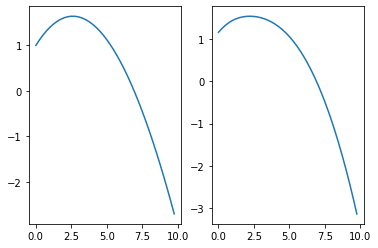

In [438]:

fig, ax = plt.subplots(1, 2)
ax[0].plot(x_test, y_test)
ax[1].plot(x_test, taylor.forward(x_test).detach().numpy())
plt.show()

# Implementación de la KAN

Finalmente, añadimos las capas KAN seguidamente en una clase para construir adecuadamente este estimador.

In [439]:


    
# Unimos las capas de la KAN según la lista de la estructura
class KAN(nn.Module):
    def __init__(self, lista_estructura, grado_taylor):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList([])
        for i in range(len(lista_estructura)-1):
            self.layers.append(
           capaKAN_taylor(lista_estructura[i], lista_estructura[i+1], grado_taylor)
            )

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x


### Entrenamiento de la KAN en un dataset de juguete:

Utilizamos la KAN para aproximar este dataset artificalmente generado $${(x, y, z): z = x^2+y^2}$$

Text(0, 0.5, 'y')

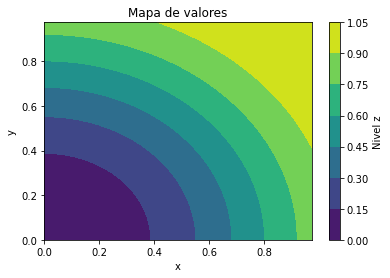

In [425]:
X = np.arange(0, 1, 0.025)
Y = np.arange(0, 1, 0.025)
X, Y = np.meshgrid(X, Y)
R = X**2 + Y**2
Z = np.sin(R)




plt.contourf(X, Y, Z, cmap="viridis")
plt.colorbar(label="Nivel z")
plt.title("Mapa de valores")
plt.xlabel("x")
plt.ylabel("y")



In [419]:
# Definimos el modelo
structure = [
             2, #Se reciben (x, y) 
             4,
            4, 
            1, 
            ]  # #Se obtiene un output final
grado_taylor = 10  #Grado de taylor de los spline
num_epochs = 200
lr = 0.01



kan = KAN(structure, grado_taylor)



# Definimos la función de coste y el optimizador. Además añadimos un regulador del descenso del gradiente
# para que vaya disminuyendo el ratio de aprendizaje.
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(kan.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)

# Guardamos los costes por epoca
train_losses = []


#Generamos el dataset.
X = torch.arange(0, 1, 0.025)
Y = torch.arange(0, 1, 0.025)
X_GRID, Y_GRID = torch.meshgrid(X, Y)
GRID = (torch.stack((X_GRID.reshape(1600, 1), Y_GRID.reshape(1600, 1)), axis = 1)).reshape(1600, 2)
Z = (X_GRID.reshape(1600, 1)**2 + Y_GRID.reshape(1600, 1)**2).reshape(1600, 1)


for epoch in range(num_epochs):
    #Inicializamos el gradiente de la kan a 0
    kan.zero_grad()
    #Realizmos el pase para comprobar cuál es el error final
    predictions = kan.forward(GRID)
    #Ejecutamos la función de coste
    train_loss = criterion(predictions, Z.unsqueeze(1))
    #Computamos los gradientes utilizando la retropropagaación
    train_loss.backward()
    #Este código se utiliza en caso de tener problemas con un coste nan (por exploding gradients)
    #torch.nn.utils.clip_grad_norm_(kan.parameters(), max_norm=1.0)
    
    #Actualizamos los parámetros
    optimizer.step()
    #Actualizamos el ratio de aprendizaje
    scheduler.step()

    if epoch % 20 == 0:
        print(f"Epoca {epoch}/{num_epochs}, Coste en el dataset de entrenamiento: {train_loss.item():.4f}")
        for i, layer in enumerate(kan.layers):
            #Con este código, podemos comprobar que hemos llegado a un mínimo local
            print('norma cuadrada de los gradientes para la capa:',i, ', ', torch.sum(layer.pesos_taylor.grad**2).item())



Epoch 0/200, Train Loss: 0.5814
norma cuadrada de los gradients para la capa: 0 ,  7.326410029709999e-19
norma cuadrada de los gradients para la capa: 1 ,  1.1255439939447665e-12
norma cuadrada de los gradients para la capa: 2 ,  9.956321491699782e-07
Epoch 20/200, Train Loss: 0.4668
norma cuadrada de los gradients para la capa: 0 ,  6.523312185890973e-05
norma cuadrada de los gradients para la capa: 1 ,  0.0018523456528782845
norma cuadrada de los gradients para la capa: 2 ,  0.08357438445091248
Epoch 40/200, Train Loss: 0.1818
norma cuadrada de los gradients para la capa: 0 ,  0.0011378054041415453
norma cuadrada de los gradients para la capa: 1 ,  0.0009147725650109351
norma cuadrada de los gradients para la capa: 2 ,  0.001373836537823081
Epoch 60/200, Train Loss: 0.1711
norma cuadrada de los gradients para la capa: 0 ,  2.869935087801423e-06
norma cuadrada de los gradients para la capa: 1 ,  5.323774166754447e-05
norma cuadrada de los gradients para la capa: 2 ,  0.000423785240855

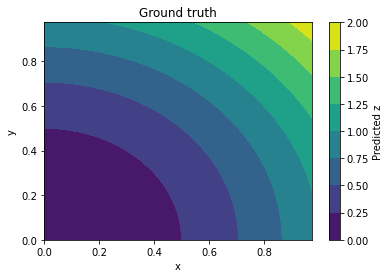

In [420]:
#Volvemos a dibujar la función para la referencia
Z = X_GRID**2 + Y_GRID**2
plt.contourf(X_GRID, Y_GRID, Z, cmap="viridis")
plt.colorbar(label=" z")
plt.title("Ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

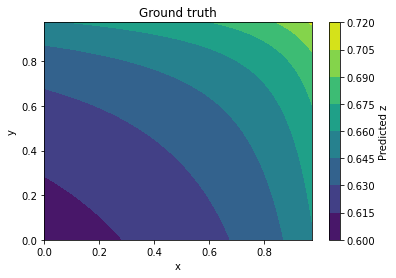

In [421]:
#Vemos cómo se ajusta la predicción con respecto a la ground truth

Z_PRED = kan.forward(GRID).reshape(40, 40)
plt.contourf(X_GRID.detach().numpy(), Y_GRID.detach().numpy(), Z_PRED.detach().numpy(), cmap="viridis")
plt.colorbar(label=" z")
plt.title("Predicciones")
plt.xlabel("x")
plt.ylabel("y")


plt.show()

# Aplicaciones de este tipo de estructura:

Este tipo de estructura es extremadamente útil para encontrar funciones para fórmulas físicas realizando experimentos, puesto que basta echar una mirada a los splines entrenados para ver cómo se construye la función final a partir de los parámetros. Además, este tipo de estimadores es extremadamente interpretable, sólamente es necesario seguir las evaluaciones de los splines para entender cómo afecta cada variable al resultado final.